In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# Load the CSV data
metadata = pd.read_csv('train.csv')

# Basic CSV EDA
print(metadata.head())
print(metadata.describe())
print(metadata.isnull().sum())

   site_id  patient_id    image_id laterality view   age  cancer  biopsy  \
0        2       10006   462822612          L   CC  61.0       0       0   
1        2       10006  1459541791          L  MLO  61.0       0       0   
2        2       10006  1864590858          R  MLO  61.0       0       0   
3        2       10006  1874946579          R   CC  61.0       0       0   
4        2       10011   220375232          L   CC  55.0       0       0   

   invasive  BIRADS  implant density  machine_id  difficult_negative_case  
0         0     NaN        0     NaN          29                    False  
1         0     NaN        0     NaN          29                    False  
2         0     NaN        0     NaN          29                    False  
3         0     NaN        0     NaN          29                    False  
4         0     0.0        0     NaN          21                     True  
            site_id    patient_id      image_id           age        cancer  \
count  5

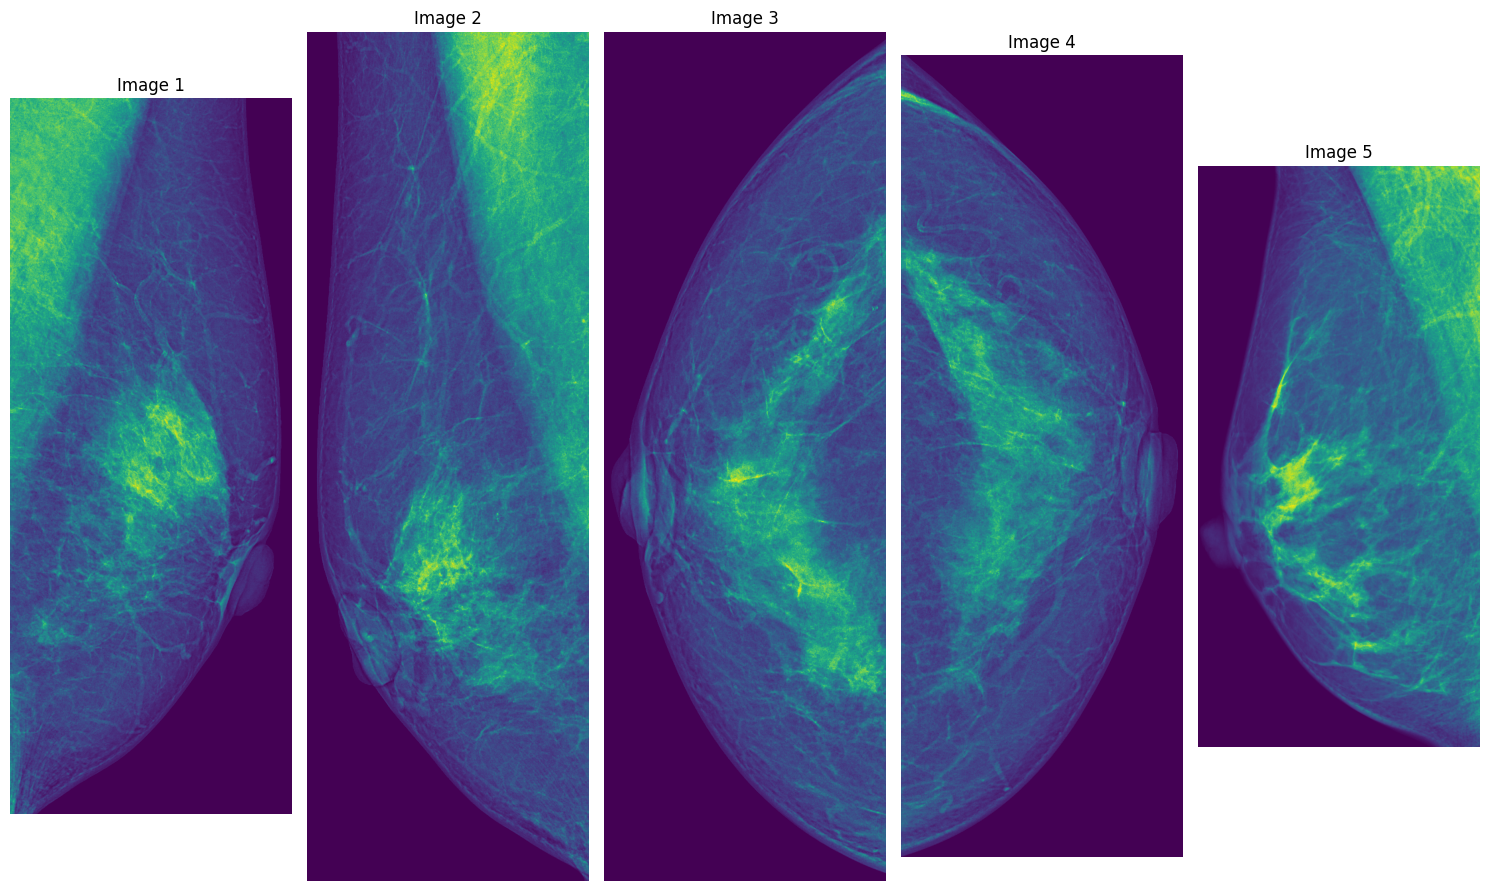

In [2]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os

# List of filenames
file_list = os.listdir('bc_1280_train_lut')

# Set up the figure size and layout
plt.figure(figsize=(16, 4))  # Adjust the size as needed

# Loop through the first N files in the file_list and display them
for i, filename in enumerate(file_list[:5]):  # Here, we're showing the first 5 images
    # Full path to the image file
    filepath = os.path.join('bc_1280_train_lut', filename)
    
    # Read the image file
    image = mpimg.imread(filepath)
    
    # Add a subplot for each image
    plt.subplot(1, 5, i + 1)  # Adjust the layout parameters as needed (rows, columns, index)
    plt.imshow(image)
    plt.title(f"Image {i+1}")
    plt.axis('off')  # Turn off axis numbers and ticks

# Show all the images
plt.tight_layout()
plt.show()

In [3]:
def create_image_path(row, base_path='bc_1280_train_lut'):
    image_id = str(int(row['image_id']))
    patient_id = str(int(row['patient_id']))
    return f"{base_path}/{patient_id}_{image_id}.png"

metadata['image_path'] = metadata.apply(create_image_path, axis=1)

In [4]:
cancer_counts=metadata.groupby('cancer').size()
# Print the result
print(cancer_counts)

cancer
0    53548
1     1158
dtype: int64


In [5]:
import pandas as pd

# Convert patient_id to string if it's not already, to prevent any loss of leading zeros
metadata['patient_id'] = metadata['patient_id'].astype(str)

# Group by 'patient_id' and filter out those groups which don't have exactly four images
valid_groups = metadata.groupby('patient_id').filter(lambda x: len(x) == 4)

# Now we create a dictionary that has patient IDs as keys and the list of image paths as values
patient_image_groups = valid_groups.groupby('patient_id')['image_path'].apply(list).to_dict()

# Display the patient IDs and their corresponding image paths for the first two patients
for patient_id in list(patient_image_groups)[:2]:
    print(f"Patient ID: {patient_id}")
    print(f"Image Paths: {patient_image_groups[patient_id]}\n")

Patient ID: 10006
Image Paths: ['bc_1280_train_lut/10006_462822612.png', 'bc_1280_train_lut/10006_1459541791.png', 'bc_1280_train_lut/10006_1864590858.png', 'bc_1280_train_lut/10006_1874946579.png']

Patient ID: 10011
Image Paths: ['bc_1280_train_lut/10011_220375232.png', 'bc_1280_train_lut/10011_270344397.png', 'bc_1280_train_lut/10011_541722628.png', 'bc_1280_train_lut/10011_1031443799.png']



In [6]:
import pandas as pd

# Convert patient_id to string if it's not already, to prevent any loss of leading zeros
metadata['patient_id'] = metadata['patient_id'].astype(str)

# Group by 'patient_id' and filter out those groups which don't have exactly four images
valid_groups = metadata.groupby('patient_id').filter(lambda x: len(x) == 4)

# Now we create a dictionary that has patient IDs as keys and the unique label as values
patient_cancer_groups = valid_groups.groupby('patient_id')['cancer'].first().to_dict()

# Display the patient IDs and their corresponding label for the first two patients
for patient_id in list(patient_cancer_groups)[:2]:
    print(f"Patient ID: {patient_id}")
    print(f"Label: {patient_cancer_groups[patient_id]}\n")

Patient ID: 10006
Label: 0

Patient ID: 10011
Label: 0



In [7]:
# Initialize a counter dictionary
count = {0: 0, 1: 0}

# Iterate over each patient's cancer group and increment the counter
for group in patient_cancer_groups.values():
    count[group] += 1

# Display the count of 0s and 1s
count

{0: 8082, 1: 151}

In [8]:
dataset = []

for patient_id, images in patient_image_groups.items():
    label = patient_cancer_groups.get(patient_id, None)  # Get the label for the current patient_id
    if label is not None:  # Check if label exists
        entry = {'patient_id': patient_id, 'images': images, 'label': label}
        dataset.append(entry)

### **DATASET_1 (Weighted Data)**

In [9]:
# First, we need to separate the records with label 0 and label 1
label_0_group = [record for record in dataset if record['label'] == 0]
label_1_group = [record for record in dataset if record['label'] == 1]

# Assuming label 1 group has the minimum count, we fix the number of 0's to match the number of 1's
fixed_label_0_group = label_0_group[:len(label_1_group)]

# Combine the fixed number of 0's with all the 1's to create a balanced dataset
balanced_dataset = fixed_label_0_group + label_1_group

### **DATASET_2 (0_850, 1_151)**

In [10]:
# Specify the number of samples you want from label 0
number_of_samples = 850

# Check if there are enough samples in label 0 group, if not use all available
if len(label_0_group) >= number_of_samples:
    selected_label_0_samples = label_0_group[:number_of_samples]
else:
    selected_label_0_samples = label_0_group

# Combine the selected samples from label 0 with all samples from label 1
balanced_dataset_2 = selected_label_0_samples + label_1_group

In [11]:
balanced_dataset_2[1]

{'patient_id': '10011',
 'images': ['bc_1280_train_lut/10011_220375232.png',
  'bc_1280_train_lut/10011_270344397.png',
  'bc_1280_train_lut/10011_541722628.png',
  'bc_1280_train_lut/10011_1031443799.png'],
 'label': 0}

In [12]:
# Assuming patient_image_groups is your dictionary
number_of_patients = len(patient_image_groups)
print("Number of patients with exactly four images:", number_of_patients)

Number of patients with exactly four images: 8233


In [13]:
from keras.preprocessing.image import load_img, img_to_array
from keras.applications.vgg16 import preprocess_input
import numpy as np
import random
import datetime
import os
from keras.models import Model
from keras.layers import Input, Dense, Flatten, concatenate
from keras.applications import VGG16
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
from tensorflow.keras.callbacks import TensorBoard

In [14]:
# Define an ImageDataGenerator with augmentation parameters
train_datagen = ImageDataGenerator(
    rotation_range=20,       # Rotate the images by up to 20 degrees
    width_shift_range=0.2,   # Shift the image width by a maximum of 20%
    height_shift_range=0.2,  # Shift the image height by a maximum of 20%
    shear_range=0.15,        # Shear the image by up to 15%
    zoom_range=0.2,          # Zoom in on the image by up to 20%
    channel_shift_range=10,  # Change the color channels by up to a value of 10
    horizontal_flip=True,    # Allow horizontal flipping of the image
    fill_mode='nearest',     # Use the nearest fill mode for new pixels
    preprocessing_function=tf.keras.applications.vgg16.preprocess_input  # Apply VGG16 preprocessing
)

# For validation data, no augmentation is applied, just rescaling and preprocessing
validation_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)

In [15]:
# Function to split dataset into training and validation sets
def split_dataset(dataset, train_size=0.8):
    """Splits the dataset into training and validation sets.
    
    Args:
        dataset (list): The complete dataset list of dictionaries.
        train_size (float): The proportion of the dataset to include in the train split.
    
    Returns:
        tuple: Two lists, (training_dataset, validation_dataset).
    """
    # Shuffle dataset to ensure random distribution
    np.random.shuffle(dataset)
    
    # Calculate the number of samples in the training set
    train_end = int(len(dataset) * train_size)
    
    # Split the dataset
    training_dataset = dataset[:train_end]
    validation_dataset = dataset[train_end:]
    
    return training_dataset, validation_dataset

# Split your dataset
training_data, validation_data = split_dataset(balanced_dataset)

In [16]:
import tensorflow as tf

def generate_data(dataset, datagen, batch_size=10, augment=False):
    while True:
        for start in range(0, len(dataset), batch_size):
            end = min(start + batch_size, len(dataset))
            batch_data = dataset[start:end]
            
            # Initialize lists for images and labels
            batch_images = [[] for _ in range(4)]  # Create a list of lists for each input
            batch_labels = []
            
            for entry in batch_data:
                # Process images and add them to the corresponding list
                for i, img_path in enumerate(entry['images']):
                    img = load_img(img_path, target_size=(224, 224))
                    img = img_to_array(img)
                    if augment:
                        img = datagen.random_transform(img)
                    img = preprocess_input(img)
                    batch_images[i].append(img)

                # Add the label
                batch_labels.append(entry['label'])
            
            # Convert lists of images and labels to tensors
            batch_images = [np.stack(images) for images in batch_images]  # Stack images for each input
            batch_labels = np.array(batch_labels)

            # Convert to tensors
            batch_images = [tf.convert_to_tensor(images, dtype=tf.float32) for images in batch_images]
            batch_labels = tf.convert_to_tensor(batch_labels, dtype=tf.float32)
            
            # Yield the batch in the correct structure
            yield tuple(batch_images), batch_labels     

### **Train_Dataset_2**

In [17]:
training_data_2, validation_data_2 = split_dataset(balanced_dataset_2)

# Create a `tf.data.Dataset` from the generator
train_dataset_2 = tf.data.Dataset.from_generator(
    lambda: generate_data(training_data_2, train_datagen, batch_size=10, augment=True),
    output_signature=(
        (tf.TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32),
         tf.TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32),
         tf.TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32),
         tf.TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32)),
        tf.TensorSpec(shape=(None,), dtype=tf.float32)
    )
)

# Similarly for the validation dataset
validation_dataset_2 = tf.data.Dataset.from_generator(
    lambda: generate_data(validation_data_2, validation_datagen, batch_size=10, augment=False),
    output_signature=(
        (tf.TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32),
         tf.TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32),
         tf.TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32),
         tf.TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32)),
        tf.TensorSpec(shape=(None,), dtype=tf.float32)
    )
)

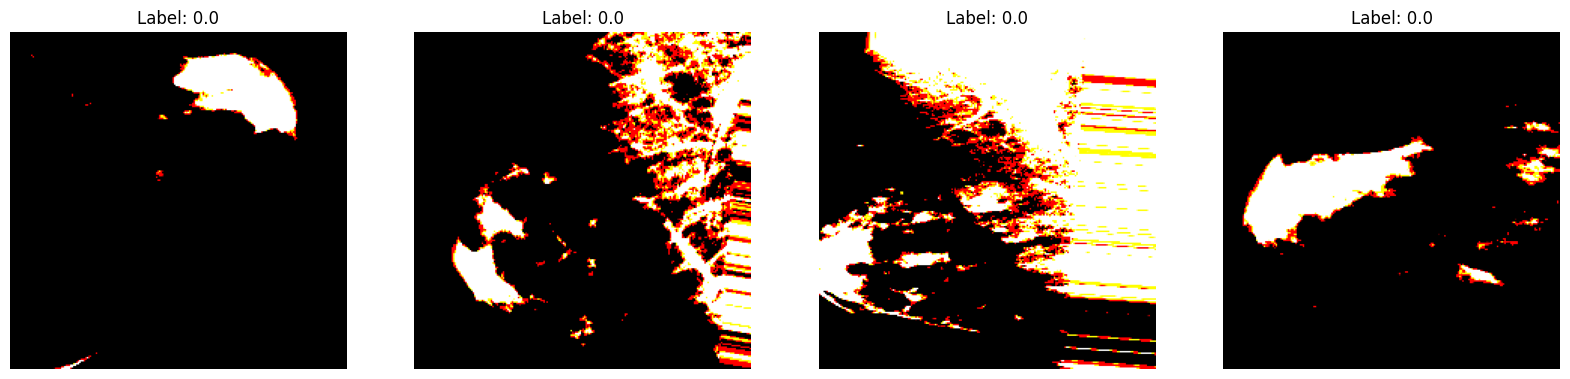

In [18]:
import matplotlib.pyplot as plt
import numpy as np

def plot_images(images, labels, n_images=4):
    """Plot a sample of images with labels."""
    fig, axes = plt.subplots(1, n_images, figsize=(20, 5))
    for i, ax in enumerate(axes):
        # Assuming images are in the format (batch, height, width, channels)
        ax.imshow(np.clip(images[i][0], 0, 1))  # Take the first image of each batch and clip values between 0 and 1
        ax.title.set_text(f'Label: {labels[0]}')
        ax.axis('off')
    plt.show()

# Fetch a single batch from the training dataset
for image_batch, label_batch in train_dataset_2.take(1):
    # Prepare images for display
    images = [image_batch[i].numpy() for i in range(4)]  # Extract each image set from the tuple
    labels = label_batch.numpy()
    
    # Use the plotting function
    plot_images(images, labels)

In [19]:
from tensorflow.keras.metrics import AUC

In [20]:
# Define a custom F1 Score metric
def f1_score(y_true, y_pred):
    y_pred = tf.round(y_pred)  # Convert probabilities to binary values (0 or 1)
    true_positives = tf.reduce_sum(tf.round(tf.clip_by_value(y_true * y_pred, 0, 1)))
    predicted_positives = tf.reduce_sum(tf.round(tf.clip_by_value(y_pred, 0, 1)))
    possible_positives = tf.reduce_sum(tf.round(tf.clip_by_value(y_true, 0, 1)))

    precision = true_positives / (predicted_positives + tf.keras.backend.epsilon())
    recall = true_positives / (possible_positives + tf.keras.backend.epsilon())
    f1_val = 2 * (precision * recall) / (precision + recall + tf.keras.backend.epsilon())
    
    return f1_val

In [21]:
# Set seeds to make the random work deterministic
np.random.seed(42)
tf.random.set_seed(42)
random.seed(42)
os.environ['PYTHONHASHSEED'] = str(42)

# Load VGG16 as the base model
base_model = VGG16(weights='imagenet', include_top=False)

# Freeze the layers of VGG16
for layer in base_model.layers:
    layer.trainable = False

# Create four input layers, one for each image
input_1 = Input(shape=(224, 224, 3))
input_2 = Input(shape=(224, 224, 3))
input_3 = Input(shape=(224, 224, 3))
input_4 = Input(shape=(224, 224, 3))

# Extract features from each input using the shared base model
features_1 = base_model(input_1)
features_2 = base_model(input_2)
features_3 = base_model(input_3)
features_4 = base_model(input_4)

# Flatten the features
flattened_features_1 = Flatten()(features_1)
flattened_features_2 = Flatten()(features_2)
flattened_features_3 = Flatten()(features_3)
flattened_features_4 = Flatten()(features_4)

# Concatenate the flattened features
concatenated = concatenate([flattened_features_1, flattened_features_2, flattened_features_3, flattened_features_4])

# Add a dense layer for classification
classification_layer = Dense(256, activation='relu')(concatenated)
output = Dense(1, activation='sigmoid')(classification_layer)  # Use 'sigmoid' for binary classification

# Create the model
model_1 = Model(inputs=[input_1, input_2, input_3, input_4], outputs=output)

# Compile the model including F1 score
model_1.compile(optimizer='adam', 
                loss='binary_crossentropy', 
                metrics=['accuracy', 'auc', f1_score])

In [22]:
model_1.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_2       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_3       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_4       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ vgg16 (Functional)  │ (None, 7, 7, 512) │ 14,714,688 │ input_layer_1[0]… │
│                     │                   │            │ input_layer_2[0]… │
│                     │                   │            │ input_layer_3[0]… │
│                     │                   │            │ input_layer_4[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 25088)     │          0 │ vgg16[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_1 (Flatten) │ (None, 25088)     │          0 │ vgg16[1][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_2 (Flatten) │ (None, 25088)     │          0 │ vgg16[2][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_3 (Flatten) │ (None, 25088)     │          0 │ vgg16[3][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 100352)    │          0 │ flatten[0][0],    │
│ (Concatenate)       │                   │            │ flatten_1[0][0],  │
│                     │                   │            │ flatten_2[0][0],  │
│                     │                   │            │ flatten_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 256)       │ 25,690,368 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 1)         │        257 │ dense[0][0]       │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 40,405,313 (154.13 MB)

 Trainable params: 25,690,625 (98.00 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [23]:
with open('model_1_summary.txt', 'w', encoding='utf-8') as fh:
    model_1.summary(print_fn=lambda x: fh.write(x + '\n'))

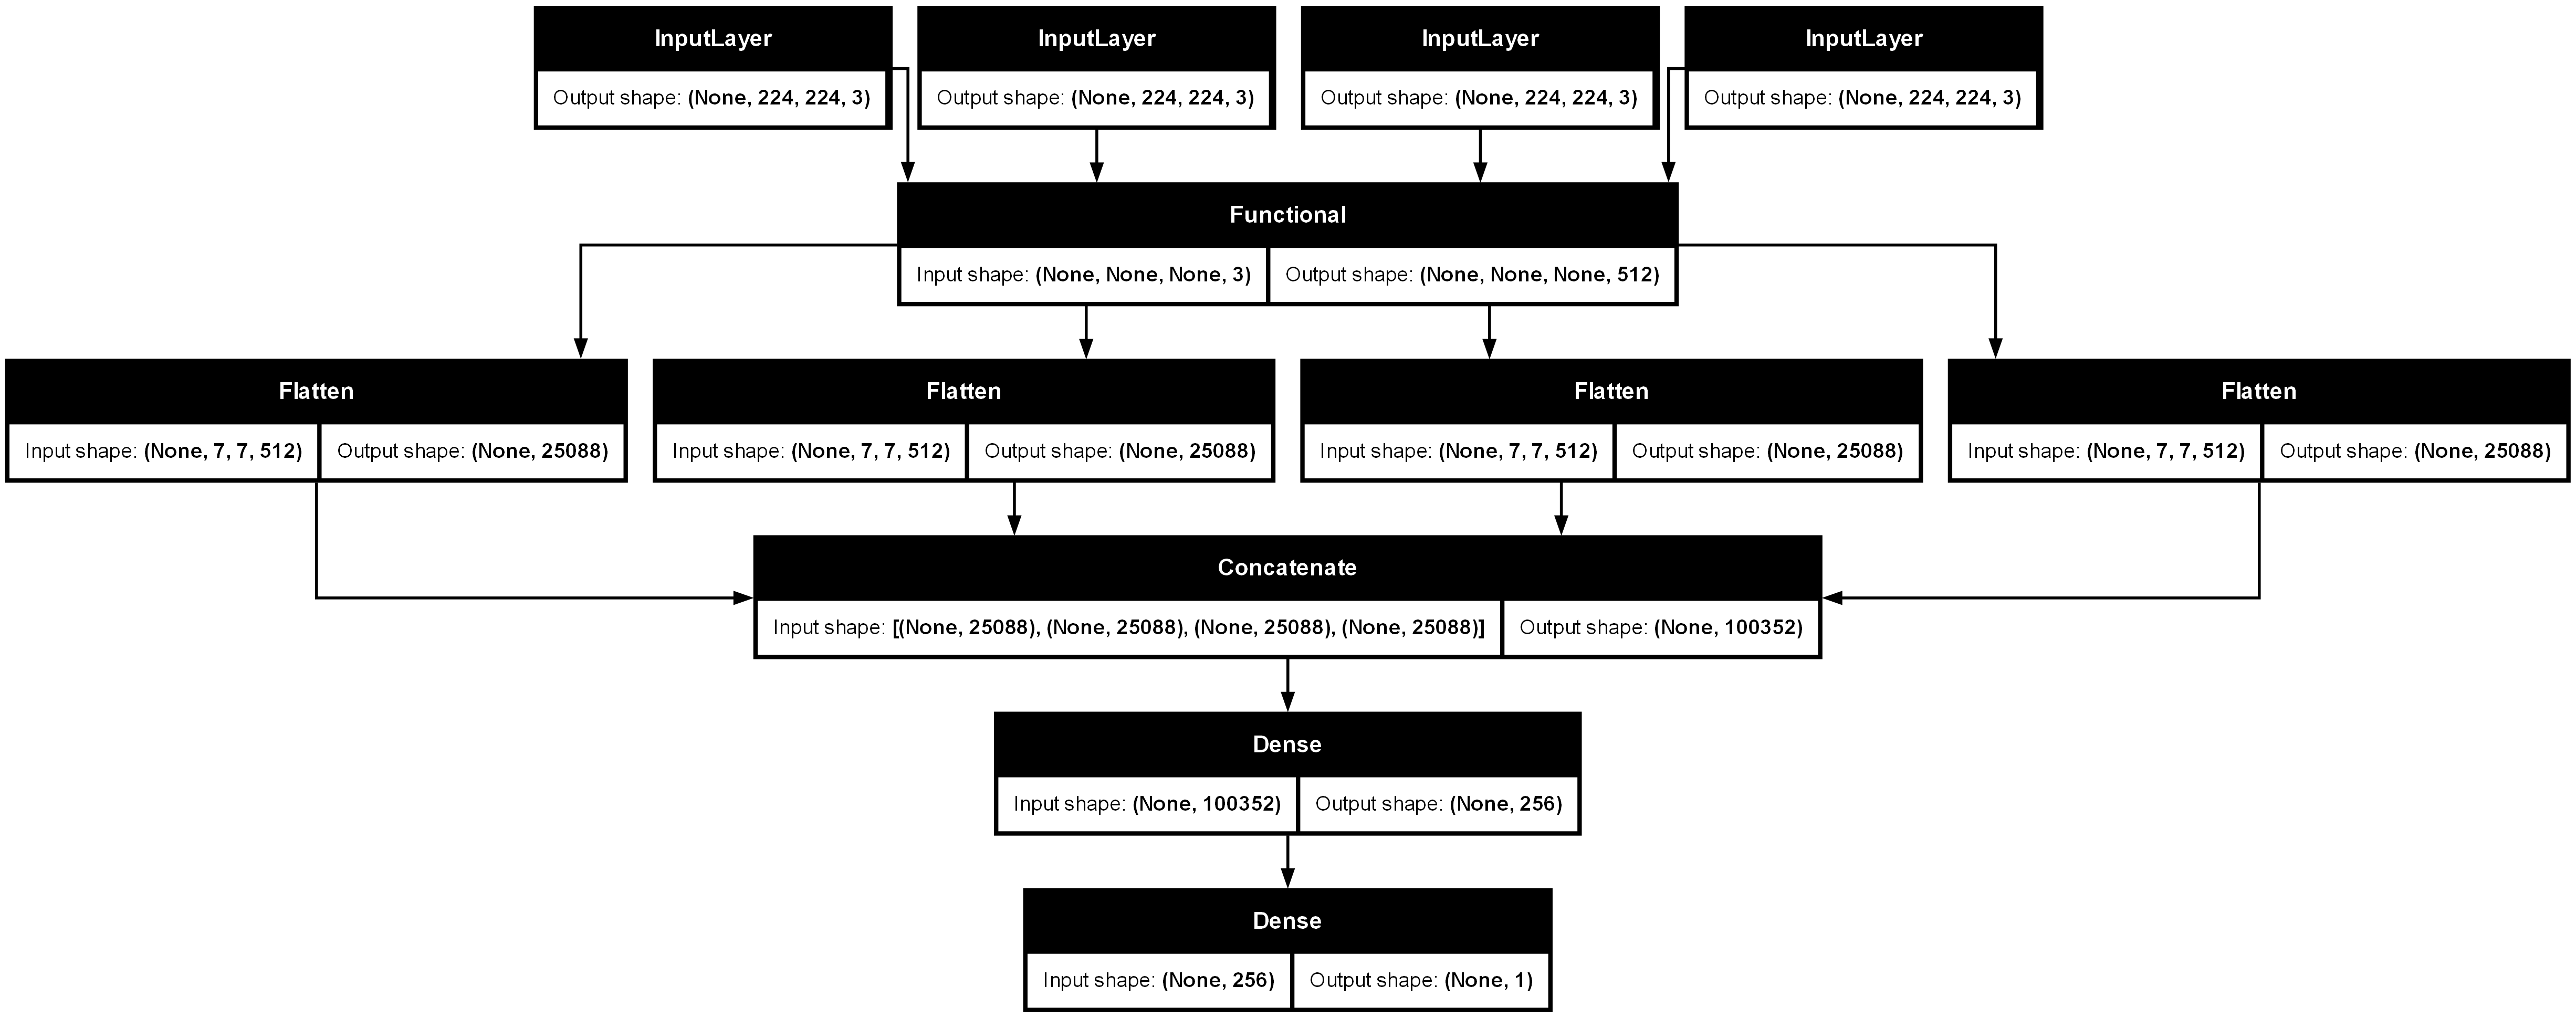

In [24]:
tf.keras.utils.plot_model(model_1, to_file='model_1.png', show_shapes=True)

In [25]:
import pydot
import tensorflow as tf

try:
    # Example of plotting a Keras model; replace 'model_1' with your actual model variable
    print("Model diagram is saved.")

except OSError:
    print("Failed to find Graphviz executables; make sure they are added to your system's PATH.")
except Exception as e:
    print(f"An unexpected error occurred: {e}")

Model diagram is saved.


In [26]:
batch_size = 10

total_training_samples = len(training_data)
total_validation_samples = len(validation_data)

# Instead of using len(dataset), define steps_per_epoch and validation_steps directly
steps_per_epoch = total_training_samples // batch_size
validation_steps = total_validation_samples // batch_size

total_training_samples_2 = len(training_data_2)
total_validation_samples_2 = len(validation_data_2)

# Instead of using len(dataset), define steps_per_epoch and validation_steps directly
steps_per_epoch_2 = total_training_samples_2 // batch_size
validation_steps_2 = total_validation_samples_2 // batch_size

In [27]:
# model.fit(
#     train_dataset,
#     steps_per_epoch=steps_per_epoch,
#     epochs=5,
#     validation_data=validation_dataset,
#     validation_steps=validation_steps
# )

In [28]:
model_1.fit(
        train_dataset_2,
        steps_per_epoch=steps_per_epoch_2,
        epochs=5,
        validation_data=validation_dataset_2,
        validation_steps=validation_steps_2,
    )

Epoch 1/5
80/80 ━━━━━━━━━━━━━━━━━━━━ 975s 12s/step - accuracy: 0.7348 - auc: 0.4978 - f1_score: 0.9583 - loss: 33.6797 - val_accuracy: 0.7850 - val_auc: 0.4784 - val_f1_score: 0.7062 - val_loss: 23.5226
Epoch 2/5
80/80 ━━━━━━━━━━━━━━━━━━━━ 957s 12s/step - accuracy: 0.7710 - auc: 0.5683 - f1_score: 0.9189 - loss: 21.0382 - val_accuracy: 0.7958 - val_auc: 0.4709 - val_f1_score: 0.3583 - val_loss: 11.7973
Epoch 3/5
80/80 ━━━━━━━━━━━━━━━━━━━━ 946s 12s/step - accuracy: 0.7819 - auc: 0.5954 - f1_score: 1.2022 - loss: 10.7711 - val_accuracy: 0.8586 - val_auc: 0.5000 - val_f1_score: 0.0000e+00 - val_loss: 7.5404
Epoch 4/5
80/80 ━━━━━━━━━━━━━━━━━━━━ 957s 12s/step - accuracy: 0.7799 - auc: 0.6076 - f1_score: 0.9437 - loss: 3.0413 - val_accuracy: 0.8639 - val_auc: 0.4939 - val_f1_score: 0.0000e+00 - val_loss: 2.2988
Epoch 5/5
41/80 ━━━━━━━━━━━━━━━━━━━━ 6:21 10s/step - accuracy: 0.8222 - auc: 0.5639 - f1_score: 0.6595 - loss: 1.3111

In [ ]:
#Saving the model
model_1.save('RSNA_VGG16.h5')  # You can specify your preferred path here

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import load_model

# Load Keras model
keras_model = load_model('RSNA_VGG16.h5')

# Convert to TensorFlow SavedModel format
tf.saved_model.save(keras_model, 'RSNA_VGG16_TF')

In [ ]:
import shutil

# Create a ZIP file
shutil.make_archive('RSNA_VGG16_HuggingFace', 'zip', '.', 'RSNA_VGG16_TF', 'config.json')